In [1]:
import numpy as np
import datetime
import matplotlib.pyplot as plt

mars = np.genfromtxt('harp_mars.dat', usecols=np.arange(0, 9))
jupiter = np.genfromtxt('harp_jupiter.dat', usecols=np.arange(0, 8))
uranus = np.genfromtxt('harp_uranus.dat', usecols=np.arange(0, 8))

mars = mars[mars[:,1] > 5]
mars = mars[mars[:,1] < 19]
mars = mars[mars[:,5] > 0]
jupiter = jupiter[jupiter[:,1] > 5]
jupiter = jupiter[jupiter[:,1] < 19]
jupiter = jupiter[jupiter[:,5] > 0]
uranus = uranus[uranus[:,1] > 5]
uranus = uranus[uranus[:,1] < 19]
uranus = uranus[uranus[:,5] > 0]

mars_etamb = mars[:,5]
jupiter_etamb = jupiter[:,5]
uranus_etamb = uranus[:,5]

mars_dates = mars[:,0]
jupiter_dates = jupiter[:,0]
uranus_dates = uranus[:,0]

y = np.concatenate((mars_etamb, jupiter_etamb, uranus_etamb), axis=0)
raw_dates = np.concatenate((mars_dates, jupiter_dates, uranus_dates), axis=0)
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in raw_dates]
yerr = np.array([.1 * etamb for etamb in y])

oldest = min(dates)
x = np.array([np.float64((date - oldest).days) + 1 for date in dates])

m_true = 0.0
b_true = 0.6
f_true = 0.5

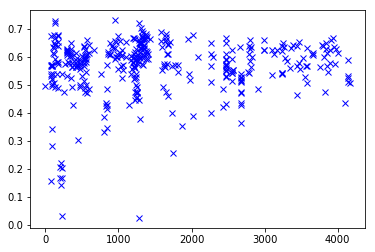

In [2]:
plt.figure(1)
plt.plot(x, y, 'bx')
plt.show()

In [3]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [4]:
import scipy.optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]

In [5]:
print(m_ml, b_ml, lnf_ml)

3.45397449845e-06 0.553187883922 -1.71502000754


In [6]:
def lnprior(theta):
    m, b, lnf = theta
    if -1.0 < m < 1.0 and 0.0 < b < 1.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [7]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [8]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [9]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [10]:
sampler.run_mcmc(pos, 500)

(array([[  1.08555686e-06,   5.58823085e-01,  -1.61263799e+00],
        [  8.50694279e-06,   5.54185615e-01,  -1.83805207e+00],
        [ -1.32069206e-06,   5.54049806e-01,  -1.71850082e+00],
        [  7.90906126e-06,   5.46636858e-01,  -1.70344195e+00],
        [  3.36104667e-06,   5.49595744e-01,  -1.69385363e+00],
        [ -3.26818474e-06,   5.59366953e-01,  -1.76415358e+00],
        [  5.68686371e-07,   5.50149728e-01,  -1.72789275e+00],
        [ -1.62940165e-06,   5.58876359e-01,  -1.77436442e+00],
        [  1.07480982e-05,   5.38775779e-01,  -1.69174863e+00],
        [  6.36464496e-06,   5.50803925e-01,  -1.70385998e+00],
        [  3.84648836e-06,   5.57166798e-01,  -1.69209311e+00],
        [  1.00561733e-05,   5.35687142e-01,  -1.69619616e+00],
        [ -2.50552029e-06,   5.54228311e-01,  -1.68653201e+00],
        [ -1.13817491e-06,   5.50907583e-01,  -1.65423377e+00],
        [ -5.57873621e-08,   5.66761656e-01,  -1.74576458e+00],
        [  8.74299478e-07,   5.61353800e

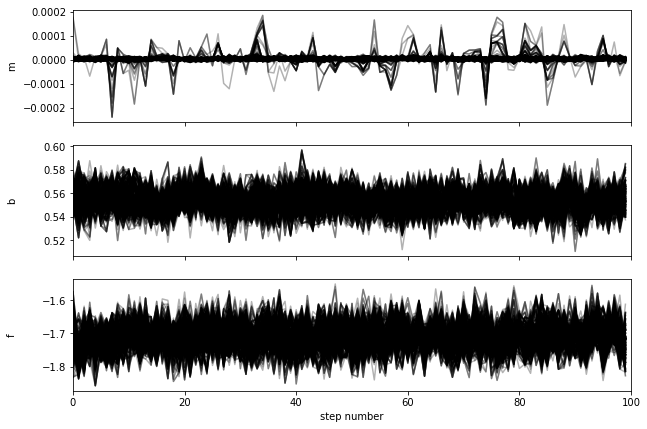

In [11]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["m", "b", "f"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.show()

In [12]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

In [13]:
import corner
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
fig.savefig("test2.png")